# Reproduce the plots in the paper

This notebook describes the steps necessary to analyze the experimental results and get the plots in the paper.
_As some cells require hours to run, the pre-computed results are in a dedicated folder: `src.utils.RESULTS_DIR`. These cells are commented out, but you can uncomment them for full reproducibility._

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

from functools import reduce

import src.utils as u
import src.rank_utils as ru
import src.rank_metrics as rm

u.ANALYSIS_DIR = u.BASE_DIR / "analysis" / "analysis_results_imputed"
u.RANKINGS_DIR = u.ANALYSIS_DIR / "Rankings"

os.chdir("..")  # move kernel to EncoderBenchmarking

# Results loading and imputation

Load the merged results, stored in the `src.utils.RESULTS_DIR` directory (default: `experimental_results`).
Missing ranks are imputed with the worst rank for each column + 1, meaning that if an encoder did not terminate for the column (combination of factors), it gets the worst rank.
Missing evaluations are not imputed.

In [2]:
df, rf = u.load_df_rf()

In [3]:
# impute missing rankings
rf = rf.fillna({col: rf[col].max()+1 for col in rf.columns})

## Sensitivity analysis
The relative performance of encoders can depend on an ML model, a quality metric, or a tuning strategy. The choice of an aggregation strategy impacts the consensus ranking.
To quantify the influence of these choices, we calculate the similarity between rankings using the Jaccard index $J$ for the sets of best encoders as well as the Spearman correlation coefficient $\rho$.
For both measures, values close to 1 indicate high agreement between rankings and low sensitivity. Conversely, values near 0 (or, for $\rho$, negative) suggest low consistency and high sensitivity.

### Sensitivity to experimental factors
We evaluate the sensitivity of encoder rankings on individual datasets with respect to an experimental factor (ML model, quality metric, or tuning strategy) by varying the factor of interest and keeping the other factors fixed, then calculating the similarity between pairs of rankings. After that, we average the result across all combinations of the other factors.
Our findings highlight the high sensitivity of results of studies comparing encoders to experimental factors, for both the full rankings and the best encoders.
They also explain why results from other studies are not comparable, as choosing different values for any factor will lead to different results.

In [4]:
jaccard_model, rho_model = u.pairwise_similarity_wide_format(rf, simfuncs=[rm.jaccard_best, rm.spearman_rho],
                                                             shared_levels=[0, 2, 3])
jaccard_tuning, rho_tuning = u.pairwise_similarity_wide_format(rf, simfuncs=[rm.jaccard_best, rm.spearman_rho],
                                                               shared_levels=[0, 1, 3])
jaccard_scoring, rho_scoring = u.pairwise_similarity_wide_format(rf, simfuncs=[rm.jaccard_best, rm.spearman_rho],
                                                                 shared_levels=[0, 1, 2])

jaccard = reduce(lambda x, y: x.fillna(y), [jaccard_model, jaccard_tuning, jaccard_scoring])
rho = reduce(lambda x, y: x.fillna(y), [rho_model, rho_tuning, rho_scoring])

jaccard.to_parquet(u.ANALYSIS_DIR / "pw_jaccard.parquet")
rho.to_parquet(u.ANALYSIS_DIR / "pw_rho.parquet")

Plot the sensitivity of results to experimental factors.

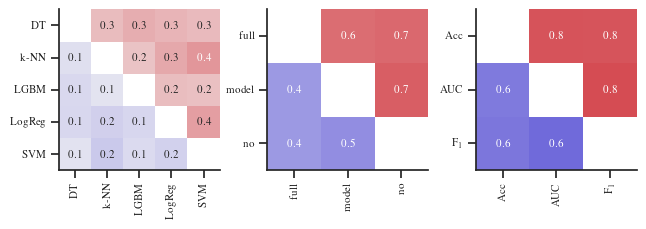

In [5]:
sims = u.load_similarity_dataframes()
rho = sims["pw_rho"]
jaccard = sims["pw_jaccard"]

factors = ["model", "tuning", "scoring"]
similarities = ["rho", "jaccard"]

sns.set(font_scale=0.8)
sns.set_style("ticks")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')

fig, axes = plt.subplots(1, len(factors))

for ax, factor in zip(axes, factors):
    df_sim = u.join_wide2long({"jaccard": jaccard, "rho": rho}, comparison_level=factor)
    title = factor
    u.heatmap_longformat_multisim(df_sim, similarities, factor, fontsize=8, annot_fontsize=8,
                                  save_plot=False, show_plot=False, title=title, ax=ax)
plt.show()

### Sensitivity to aggregation strategy

To evaluate the impact of the aggregation strategy on the consensus ranking, we apply the same procedure as above to consensus rankings instead of rankings on individual datasets.
For example, Spearman's $\rho$ between consensus rankings obtained with Q-M and Q-Md averaged across all ML models, tuning strategies, and quality metrics is 0.8.

While some aggregation strategies show strong similarities, different strategies yield very different consensus rankings in general.
This is particularly evident for Jaccard index $J$, indicating the high sensitivity of the best encoders to the rank aggregation strategy.

We begin by computing the consensus rankings with different aggregation strategies, imputing missing values in a column with the worst rank+1 as for the original rankings.

In [7]:
consensuses = list()

# --- Aggregation for all aggregation strategies except Nemenyi
consensuses.append(ru.Aggregator(df, rf).aggregate(verbose=True, ignore_strategies=["nemenyi rank", "kemeny rank"]).aggrf)

# --- Aggregation with Nemenyi with different significance levels
for alpha in [0.01, 0.05, 0.1]:
    consensuses.append(ru.Aggregator(df, rf).aggregate(verbose=True, strategies=["nemenyi rank"], alpha=alpha).aggrf)

aggrf = pd.concat(consensuses, axis=1)
# impute missing rankings
aggrf = aggrf.fillna({col: aggrf[col].max()+1 for col in aggrf.columns})
aggrf.to_parquet(u.ANALYSIS_DIR / "consensuses.parquet")

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

We then compute the similarity between different consensuses ...

In [8]:
aggrf = u.load_aggrf().rename(columns=u.AGGREGATION_NAMES, level="aggregation")
agg_jaccard, agg_rho = u.pairwise_similarity_wide_format(aggrf,
                                                         simfuncs=[rm.jaccard_best,
                                                                   rm.spearman_rho],
                                                         shared_levels=slice(-1))

agg_jaccard.to_parquet(u.ANALYSIS_DIR / "pw_AGG_jaccard.parquet")
agg_rho.to_parquet(u.ANALYSIS_DIR / "pw_AGG_rho.parquet")

... and finally plot it.

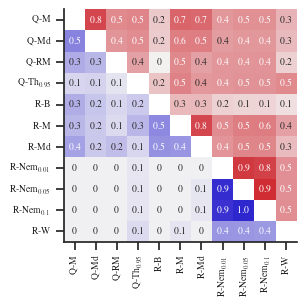

In [9]:
aggsims = u.load_aggregated_similarity_dataframes()
agg_jaccard = aggsims["pw_AGG_jaccard"]
agg_rho = aggsims["pw_AGG_rho"]

df_sim = u.join_wide2long({"rho": agg_rho, "jaccard": agg_jaccard}, comparison_level="aggregation")

sns.set_style("ticks")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')

fig, ax = plt.subplots(1, 1, figsize=(3, 3.3))
u.heatmap_longformat_multisim(df_sim, ["rho", "jaccard"], "aggregation", fontsize=7, annot_fontsize=7,
                              save_plot=False, show_plot=True, ax=ax, summary_statistic="mean", title=None)

## Replicability

Replicability is the property of a benchmark of obtaining consistent results from different data. We quantify replicability by comparing consensus rankings aggregated on two disjoint samples of datasets of equal size.
Each data point represents 100 iterations of randomly selecting two disjoint sets of datasets and applying multiple aggregation strategies. We exclude R-Kem due to its high computational complexity.
Even with 25 datasets, replicability is moderate: this suggests that consensus rankings vary significantly depending on the data.
Results from logistic regression tend to exhibit the highest replicability among ML models, while decision trees show the lowest.

The next cells perform the replicability analysis and plot the results.

In [14]:
df, rf = u.load_df_rf()
for tuning in ["no", "model", "full"]:
    sample_sizes = [5, 10, 15]
    if tuning == "no":
        sample_sizes.extend([20, 25])
    ru.replicability_analysis(df, rf, tuning, sample_sizes=sample_sizes, repetitions=5, append_to_existing=False, save=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
u.lineplot_replicability(hue="model", show=True)

## Comparing encoders
We now examine the ranks of encoders limited to decision trees, logistic regression, and all ML models.

The left subplot shows the rank of encoders from the experiments with decision trees across all datasets, quality metrics, and tuning strategies.
One-Hot is the best-performing encoder; however, Nemenyi tests at a significance level of 0.05 fail to reject that the average rank of One-Hot is the same as that of the other encoders.

The central subplot features the encoder ranks for logistic regression, where four encoders, namely One-Hot, Sum, Binary, and Weight of Evidence, consistently achieve higher ranks compared to the others.
Nemenyi tests confirm that this difference in ranks is significant.
These results indicate low replicability of the results for decision trees and higher replicability for logistic regression.

The right plot presents the ranks of encoders across all datasets, ML models, quality metrics, and tuning strategies.
Similarly to logistic regression, One-Hot, Sum, Binary, and Weight of Evidence consistently achieve significantly higher average ranks compared to the other encoders, again confirmed by Nemenyi tests.
We recommend these four encoders as the preferred choices in practical applications.
This conclusion contradicts other studies reporting a suboptimal performance of One-Hot~\cite{cerda_similarity_2018, pargent_regularized_2022}.

Our findings also reveal that Drop performs significantly worse than all other encoders, i.e., encoding categorical attributes generally yields better results than dropping them.

In [ ]:
rf = u.load_rf()
models = [None, "DTC", "LR"]

fig, axes = plt.subplots(1, len(models))
for ax, model in zip(axes.flatten(), models):
    u.boxplot_encoder_ranks(rf, ax, model)
    ax.set_title(u.FACTOR_LATEX["model"][model])
sns.despine(left=True, trim=True)
plt.tight_layout(w_pad=0.5)
plt.show()